In [4]:
import pandas as pd
import json
# from unsloth import FastLanguageModel
# from unsloth.chat_templates import get_chat_template
# from unsloth import is_bfloat16_supported
# from trl import SFTTrainer
from transformers import TrainingArguments, HfArgumentParser
from dataclasses import dataclass
from datasets import Dataset
import torch_optimizer
import torch

In [7]:
a = torch.tensor([0, 0, 0, 1, 1, 0])
idx = [i for i in a.shape if i > 0]
idx

[tensor(1), tensor(1)]

In [17]:
import os, json
INTERSTING_K = [1, 5, 10]
NUM_INTERESTING_FILES = 0
for folder in os.listdir("./train_outputs"):
    flag = True
    for k in INTERSTING_K:
        if f"[WeightLoRA, k={k}]" in folder:
            flag = False
    if flag:
        continue
    NUM_INTERESTING_FILES += 1
    with open(f"./train_outputs/{folder}/all_results.json", "r") as f:
        all_results = json.load(f)
        #print(all_results)
        for key in all_results.keys():
            if "active_adapters_" in key:
                tmp = all_results[key].split(".")
                all_results[key] = f"{tmp[8].split('_')[0]}#{tmp[5]}"
        print(all_results)
    with open(f"./train_outputs/{folder}/all_results.json", "w") as f:
        json.dump(all_results, f, sort_keys=True, indent=4)
print(NUM_INTERESTING_FILES)

{'active_adapters_1': 'value#5', 'active_adapters_10': 'value#11', 'active_adapters_2': 'value#6', 'active_adapters_3': 'value#7', 'active_adapters_4': 'value#8', 'active_adapters_5': 'value#9', 'active_adapters_6': 'key#10', 'active_adapters_7': 'value#10', 'active_adapters_8': 'query#11', 'active_adapters_9': 'key#11', 'epoch': 1.4593824228028502, 'eval_accuracy': 0.9472477064220184, 'eval_loss': 0.15586502850055695, 'eval_runtime': 2.349, 'eval_samples': 872, 'eval_samples_per_second': 371.224, 'eval_steps_per_second': 11.92, 'total_flos': 6499006338439680.0, 'train_loss': 0.2506979462923482, 'train_memory_gb': 6.5331926345825195, 'train_runtime': 10.963231666666667, 'train_samples': 67349, 'train_samples_per_second': 149.445, 'train_steps_per_second': 0.778}
{'active_adapters_1': 'value#8', 'active_adapters_2': 'value#9', 'active_adapters_3': 'value#10', 'active_adapters_4': 'key#11', 'active_adapters_5': 'value#11', 'epoch': 1.4593824228028502, 'eval_accuracy': 0.9426605504587156,

In [52]:
df = pd.DataFrame(columns=TASK_NAMES, index=TASK_NAMES, dtype=float)
df.loc["cola", "mnli"] = 1
df

,cola,mnli,mrpc,qnli,qqp,rte,sst2,stsb
cola,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
mnli,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mrpc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
qnli,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
qqp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sst2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
stsb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
from transformers import get_scheduler
import torch
optimizer = torch.optim.SGD()
scheduler = get_scheduler(
    name="linear", 
    optimizer=optimizer,
    num_warmup_steps=training_args.warmup_steps,
    num_training_steps=training_args.max_fat_steps
)

RuntimeError: Could not infer dtype of NoneType

In [22]:
o = torch.zeros([5, 2], requires_grad=True)
b = torch.rand_like(o)
a = torch.zeros_like(o, requires_grad=True)
b = torch.concat([b, a], dim=0)
b

tensor([[0.6414, 0.9626],
        [0.6874, 0.0178],
        [0.5703, 0.3742],
        [0.9114, 0.7325],
        [0.5870, 0.7662],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000]], grad_fn=<CatBackward0>)

In [5]:
import os, json
import pandas as pd
TASK_NAMES = ["cola", "mnli", "mrpc", "qnli", "qqp", "sst2", "stsb"]
INTERSTING_K = [1, 5, 10]
df_all = {}
for k in INTERSTING_K:
    df_all[k] = pd.DataFrame(columns=TASK_NAMES, index=TASK_NAMES, dtype=float)
    for task_name_1 in TASK_NAMES:
        folder_1 = f"./train_outputs/[WeightLoRA, k={k}] {task_name_1}"
        with open(f"{folder_1}/all_results.json", "r") as f:
            all_results = json.load(f)
            active_adapters_1 = []
            for key in all_results.keys():
                if "active_adapters_" in key:
                    active_adapters_1.append(all_results[key])
        for task_name_2 in TASK_NAMES:
            folder_2 = f"./train_outputs/[WeightLoRA, k={k}] {task_name_2}"
            with open(f"{folder_2}/all_results.json", "r") as f:
                all_results = json.load(f)
                active_adapters_2 = []
                for key in all_results.keys():
                    if "active_adapters_" in key:
                        active_adapters_2.append(all_results[key])
            v = sum(x == y for x, y in zip(active_adapters_1, active_adapters_2))
            df_all[k].loc[task_name_1, task_name_2] = float(v) / k
            df_all[k].loc[task_name_2, task_name_1] = float(v) / k

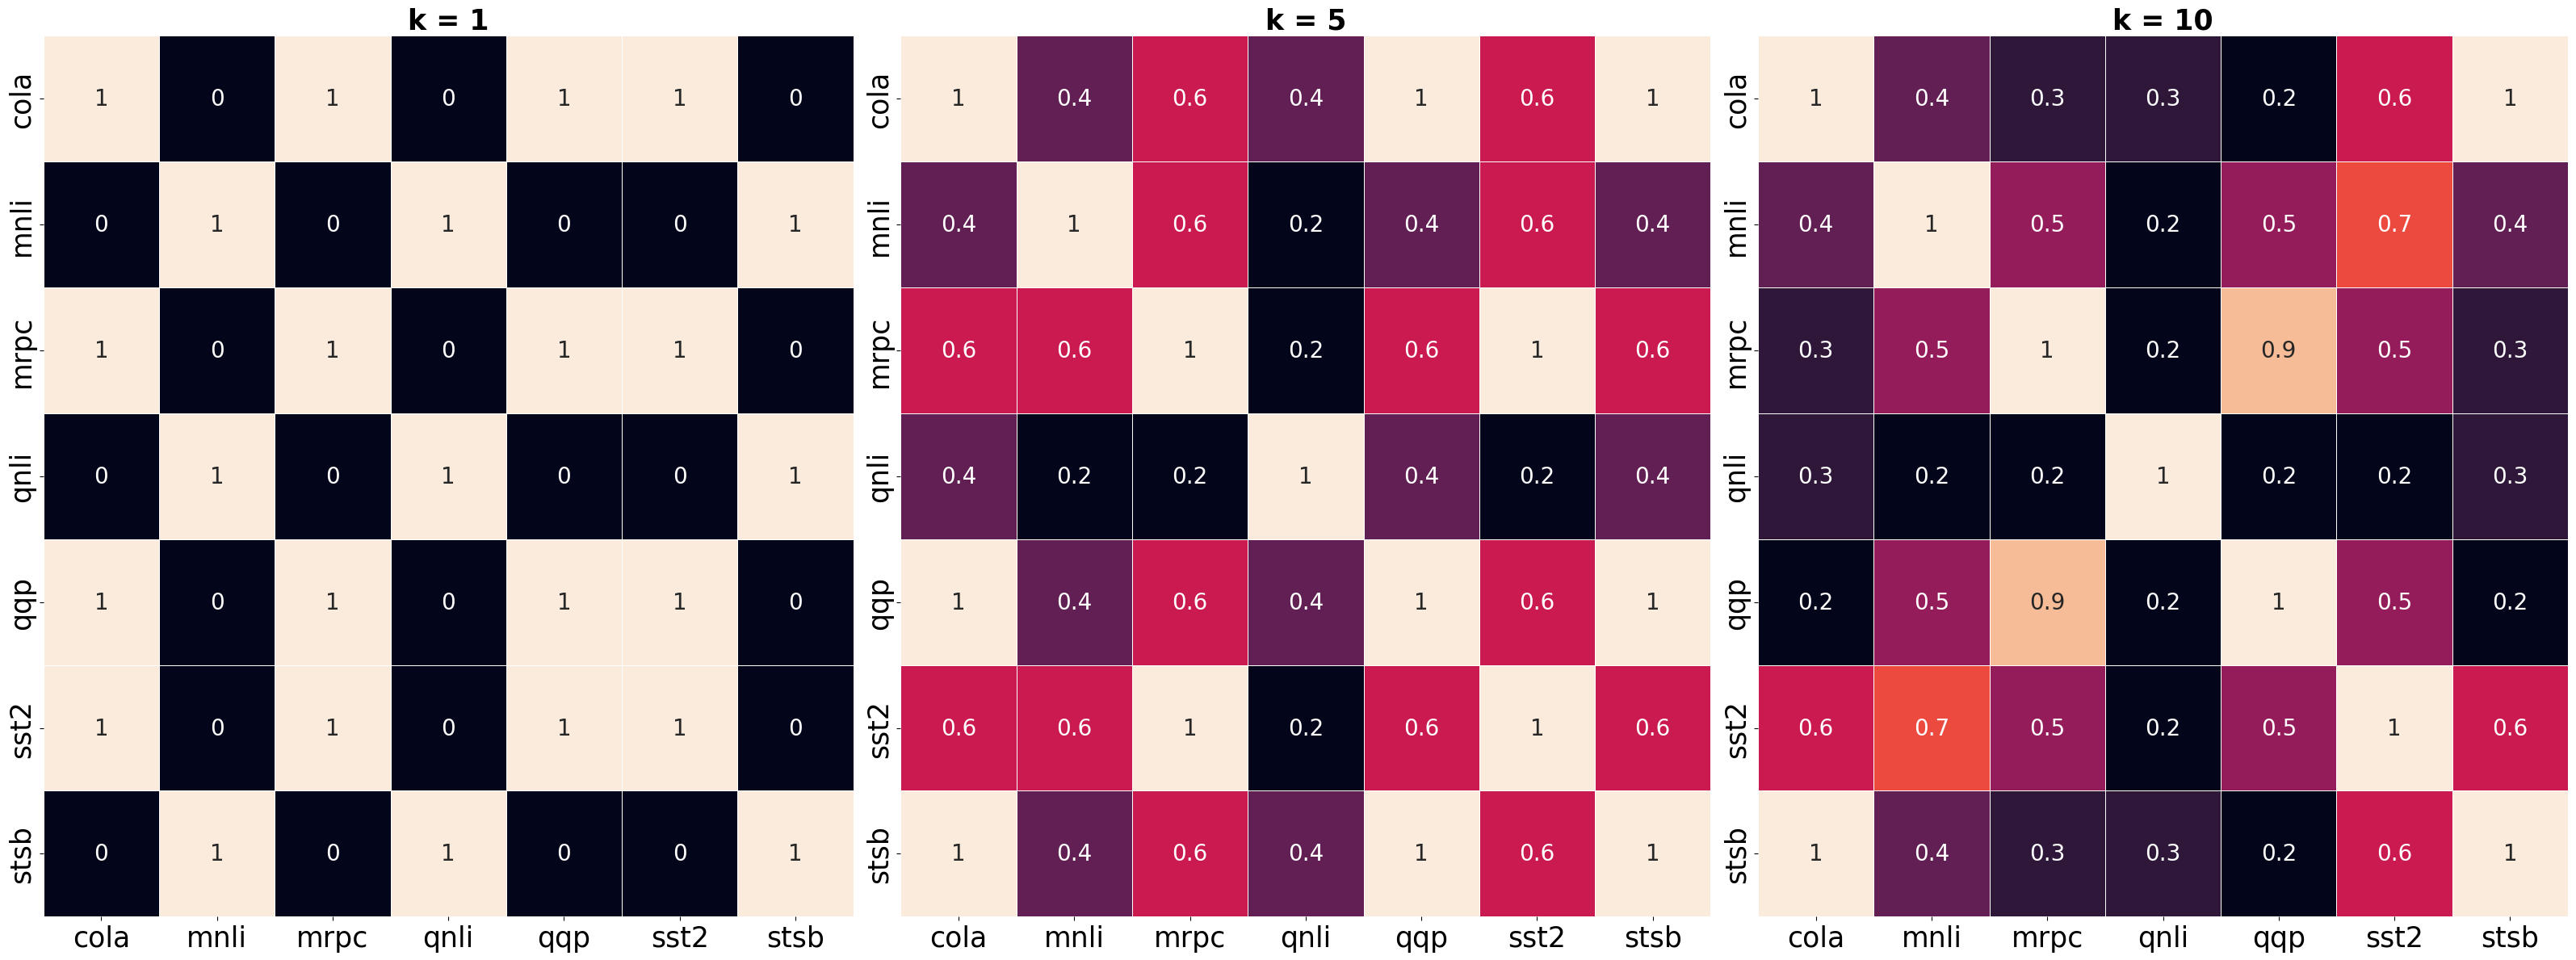

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
# Set up the matplotlib figure
plt.rc('axes', titlesize=20, titleweight='bold') #fontsize of the title
plt.rc('axes', labelsize=25) #fontsize of the x and y labels
plt.rc('xtick', labelsize=25) #fontsize of the x tick labels
plt.rc('ytick', labelsize=25) #fontsize of the y tick labels
plt.rc('legend', fontsize=15) #fontsize of the legend
f, ax = plt.subplots(1, len(INTERSTING_K), figsize=(32, 12))
plt.title("Weight LoRA analysis")
for i, k in enumerate(INTERSTING_K):
    ax[i].set_title(f"k = {k}", fontsize=25)
    sns.heatmap(df_all[k], ax=ax[i], annot=True, linewidth=.5, 
                annot_kws={"fontsize":20}, cbar=False)
plt.tight_layout()
plt.savefig("zlp.pdf")
plt.show()

In [36]:
!pip install seaborn

  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 3.3 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [25]:
from peft import LoraConfig, WeightLoraConfig
target_modules=['up_proj', 'down_proj', 'gate_proj', 
                    'k_proj', 'q_proj', 'v_proj', 'o_proj']
peft_config = WeightLoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=target_modules
)

In [26]:
peft_config.__class__.__name__

'WeightLoraConfig'

In [2]:
@dataclass
class ModelArguments:
    #model_name: str = "/media/ssd-3t/akazakov/llama31instr/models--meta-llama--Meta-Llama-3.1-8B-Instruct/snapshots/07eb05b21d191a58c577b4a45982fe0c049d0693"
    # model_name: str = "unsloth/Meta-Llama-3.1-8B" 
    #model_name: str = "unsloth/Meta-Llama-3.1-8B-bnb-4bit"
    model_name: str = "FacebookAI/roberta-base"
    max_seq_length: int = 1000
    dtype: str = None
    load_in_4bit: bool = False

@dataclass
class TrainingArguments(TrainingArguments):
    per_device_train_batch_size: int = 16
    gradient_accumulation_steps: int = 4
    warmup_steps: int = 5
    num_train_epochs: int = 5
    learning_rate: float = 1e-10
    logging_steps: int = 1
    optim: str = "adamw_hf"
    weight_decay: float = 0.01
    lr_scheduler_type: str = "linear"
    seed: int = 18
    output_dir: str = "train_outputs"
    # output_dir: str = None
    sign_step: int = 5000
    max_grad_norm: float = 1.0
    max_steps: int = 2 # overrides num_train_epochs
    report_to: str = "none" # "none" or "wandb"
 
@dataclass
class DataArguments:
    train_file: str = 'data/train_ft_short_system.jsonl'

In [3]:
import pipelines.adapters as adapters
import pipelines.optimizers as optimizers
import pipelines.utils as utils
%load_ext autoreload
%autoreload 2

In [4]:
model_args = ModelArguments
training_args = TrainingArguments
utils.set_seed(18)
device = utils.set_device(3)

There are 8 GPU(s) available.
We will use the GPU: NVIDIA A100-PCIE-40GB


In [5]:
from transformers import AutoTokenizer, AutoModelForCausalLM
model = AutoModelForCausalLM.from_pretrained(
    model_args.model_name,
    load_in_8bit=model_args.load_in_4bit,
    device_map=device
)
tokenizer = AutoTokenizer.from_pretrained(model_args.model_name)
# print(model)

If you want to use `RobertaLMHeadModel` as a standalone, add `is_decoder=True.`
/home/shkodnik/Sber_Lora/ShkodnikVenv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
from peft import WeightLoraConfig, LoraConfig, LoKrConfig
from peft import LoKrModel, LoraModel, WeightLoraModel
from peft import get_peft_model
from peft import PeftConfig, PeftType
target_modules = ["query", "key", "value"]
weight_lora_config = LoraConfig(
    r=8,
    lora_alpha=8,
    target_modules=target_modules,
    # rank_dropout=0.0,
    # module_dropout=0.0,
)
# model = WeightLoraModel(model, weight_lora_config, adapter_name="default")
# model = LoraModel(model, weight_lora_config, adapter_name="default")
model = get_peft_model(model, weight_lora_config)
model.print_trainable_parameters()
print(model)

trainable params: 442,368 || all params: 125,139,801 || trainable%: 0.3535
PeftModel(
  (base_model): LoraModel(
    (model): RobertaForCausalLM(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Identity()
                    )
                    

In [7]:
import datasets
dataset_name = 'cais/mmlu'
dataset_config_name = 'philosophy'
dataset = datasets.load_dataset(dataset_name, dataset_config_name)
train = utils.make_mlm_dataset_form_mmlu(dataset['test'])
test = utils.make_mlm_dataset_form_mmlu(dataset['validation'])
dataset = datasets.DatasetDict({"test" : test, "train" : train})
def tokenize_function(examples):
    return tokenizer(examples['text'], return_special_tokens_mask=True)
tokenized_dataset = dataset.map(
    tokenize_function,
    batched=True
)
print(tokenized_dataset)

Map: 100%|██████████| 311/311 [00:00<00:00, 10784.86 examples/s]

DatasetDict({
    test: Dataset({
        features: ['text', 'input_ids', 'attention_mask', 'special_tokens_mask'],
        num_rows: 34
    })
    train: Dataset({
        features: ['text', 'input_ids', 'attention_mask', 'special_tokens_mask'],
        num_rows: 311
    })
})


In [50]:
# for name, param in model.named_parameters():
#     if "lm_head" in name or "embed" in name:
#         param.requires_grad = True

In [14]:
model.named_parameters()

<generator object Module.named_parameters at 0x7f8760328140>

In [15]:
from transformers import get_scheduler
optimizer = optimizers.AdamW(model.parameters(), 
                                 lr=training_args.learning_rate,
                                 weight_decay=training_args.weight_decay)
scheduler = get_scheduler(name=training_args.lr_scheduler_type, 
                            optimizer=optimizer, 
                            num_warmup_steps=training_args.warmup_steps,
                            num_training_steps=training_args.max_steps)

[autoreload of pipelines.optimizers failed: Traceback (most recent call last):
  File "/home/shkodnik/Sber_Lora/ShkodnikVenv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/shkodnik/Sber_Lora/ShkodnikVenv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/home/shkodnik/Sber_Lora/ShkodnikVenv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/shkodnik/Sber_Lora/ShkodnikVenv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/shkodnik/Sber_Lora/ShkodnikVenv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/shkodnik/Sber_Lora/ShkodnikVenv/li

In [16]:
import transformers
run_name = "test"
trainer = transformers.Trainer(
    model=model,
    tokenizer=tokenizer,
    #train_dataset=dataset,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    args=TrainingArguments(
        max_steps=10,
        # learning_rate=1e-3, 
        # fp16=True, 
        output_dir=training_args.output_dir, 
        use_cpu=False, 
        save_safetensors=False,
        # report_to=report_to,
        report_to="none",
        logging_steps=1,
        # run_name=f"prob={int(prob*100)}/100_k={k}",
        run_name=run_name,
        # run_name="test",
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm_probability=0.15),
    optimizers=[optimizer, scheduler]
)

trainer_stats = trainer.train()

max_steps is given, it will override any value given in num_train_epochs


274


Step,Training Loss
1,10.825100
2,10.825100
3,10.825100
4,10.825100
5,10.825100
6,10.825100
7,10.825100
8,10.825100
9,10.825100
10,10.825100


274
274
274
274
274
274
274
274
274


/home/shkodnik/Sber_Lora/ShkodnikVenv/lib/python3.11/site-packages/peft/utils/other.py:629: UserWarning: Unable to fetch remote file due to the following error (ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: b6dd6655-0be4-421f-963d-54d210a62472)') - silently ignoring the lookup for the file config.json in FacebookAI/roberta-base.
  warnings.warn(
/home/shkodnik/Sber_Lora/ShkodnikVenv/lib/python3.11/site-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in FacebookAI/roberta-base - will assume that the vocabulary was not modified.
  warnings.warn(


: 

In [17]:
from trl import SFTTrainer
?SFTTrainer

Init signature:
SFTTrainer(
    model: Union[transformers.modeling_utils.PreTrainedModel, torch.nn.modules.module.Module, str, NoneType] = None,
    args: Optional[transformers.training_args.TrainingArguments] = None,
    data_collator: Optional[transformers.data.data_collator.DataCollator] = None,
    train_dataset: Optional[datasets.arrow_dataset.Dataset] = None,
    eval_dataset: Union[datasets.arrow_dataset.Dataset, Dict[str, datasets.arrow_dataset.Dataset], NoneType] = None,
    tokenizer: Optional[transformers.tokenization_utils_base.PreTrainedTokenizerBase] = None,
    model_init: Optional[Callable[[], transformers.modeling_utils.PreTrainedModel]] = None,
    compute_metrics: Optional[Callable[[transformers.trainer_utils.EvalPrediction], Dict]] = None,
    callbacks: Optional[List[transformers.trainer_callback.TrainerCallback]] = None,
    optimizers: Tuple[torch.optim.optimizer.Optimizer, torch.optim.lr_scheduler.LambdaLR] = (None, None),
    preprocess_logits_for_metrics: Opti

In [ ]:
5e-4

In [71]:
for name, param in model.named_parameters():
    if "lora_A" in name:
        print(name, "; sum = ", param.sum().item())

base_model.model.roberta.encoder.layer.0.attention.self.query.lora_A.default.weight ; sum =  nan
base_model.model.roberta.encoder.layer.0.attention.self.key.lora_A.default.weight ; sum =  nan
base_model.model.roberta.encoder.layer.0.attention.self.value.lora_A.default.weight ; sum =  nan
base_model.model.roberta.encoder.layer.1.attention.self.query.lora_A.default.weight ; sum =  nan
base_model.model.roberta.encoder.layer.1.attention.self.key.lora_A.default.weight ; sum =  nan
base_model.model.roberta.encoder.layer.1.attention.self.value.lora_A.default.weight ; sum =  nan
base_model.model.roberta.encoder.layer.2.attention.self.query.lora_A.default.weight ; sum =  nan
base_model.model.roberta.encoder.layer.2.attention.self.key.lora_A.default.weight ; sum =  nan
base_model.model.roberta.encoder.layer.2.attention.self.value.lora_A.default.weight ; sum =  nan
base_model.model.roberta.encoder.layer.3.attention.self.query.lora_A.default.weight ; sum =  nan
base_model.model.roberta.encoder.lay